In [71]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, get_peft_model, PeftModel

model_name = "unsloth/Llama-3.2-1B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForCausalLM.from_pretrained(model_name)

peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj","v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

peft_model = get_peft_model(base_model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 851,968 || all params: 1,236,666,368 || trainable%: 0.0689


In [72]:
peft_model.merge_adapter()
peft_model.print_trainable_parameters()

trainable params: 851,968 || all params: 1,236,666,368 || trainable%: 0.0689


In [73]:
peft_model = get_peft_model(base_model, peft_config, 'other_lora')
peft_model.print_trainable_parameters()

trainable params: 851,968 || all params: 1,237,518,336 || trainable%: 0.0688


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/peft/tuners/lora/model.py:431: UserWarning: Adapter cannot be set when the model is merged. Unmerging the model first.
  warnings.warn("Adapter cannot be set when the model is merged. Unmerging the model first.")


In [74]:
peft_model.unmerge_adapter()
peft_model.print_trainable_parameters()

trainable params: 851,968 || all params: 1,237,518,336 || trainable%: 0.0688


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/peft/tuners/lora/layer.py:544: UserWarning: Already unmerged. Nothing to do.
  warnings.warn("Already unmerged. Nothing to do.")


In [75]:
model_name = "unsloth/Llama-3.2-1B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForCausalLM.from_pretrained(model_name)

peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj","v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

peft_model = get_peft_model(base_model, peft_config)

In [84]:
import os
import glob

clients = [i for i in range(20)]
c_params = [[] for i in range(20)]

for c in clients:
    path = f'output_multitask/Llama-3.2-1B/feddpa-1domain_multitask_clustered_c20s5_i5_b16a1_l1024_r8a16_20250407111210/local_adapters/checkpoint-*_client{c}'
    ckpts = glob.glob(path)
    latest_ckpt = max(ckpts, key=os.path.getctime)

    latest_ckpt = latest_ckpt + '/local'
    peft_model = PeftModel.from_pretrained(
        base_model,
        latest_ckpt,
        adapter_name='local',
    )
    #get adapter parameters
    for name, param in peft_model.named_parameters():
        if 'lora_B.local' in name:
            print(name)
            c_params[c].append(param.data)
        

base_model.model.model.layers.0.self_attn.q_proj.lora_B.local.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_B.local.weight
base_model.model.model.layers.1.self_attn.q_proj.lora_B.local.weight
base_model.model.model.layers.1.self_attn.v_proj.lora_B.local.weight
base_model.model.model.layers.2.self_attn.q_proj.lora_B.local.weight
base_model.model.model.layers.2.self_attn.v_proj.lora_B.local.weight
base_model.model.model.layers.3.self_attn.q_proj.lora_B.local.weight
base_model.model.model.layers.3.self_attn.v_proj.lora_B.local.weight
base_model.model.model.layers.4.self_attn.q_proj.lora_B.local.weight
base_model.model.model.layers.4.self_attn.v_proj.lora_B.local.weight
base_model.model.model.layers.5.self_attn.q_proj.lora_B.local.weight
base_model.model.model.layers.5.self_attn.v_proj.lora_B.local.weight
base_model.model.model.layers.6.self_attn.q_proj.lora_B.local.weight
base_model.model.model.layers.6.self_attn.v_proj.lora_B.local.weight
base_model.model.model.layers.7.se

<Axes: >

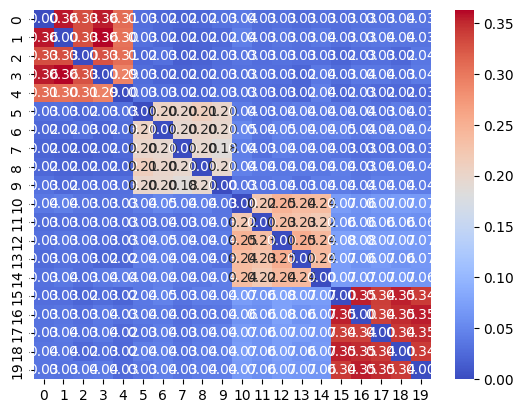

In [85]:
#similarity betweem adapters

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#flatten the list of parameters
c_params = [np.concatenate([p.flatten().cpu().numpy() for p in params]) for params in c_params]

sims = np.zeros((len(clients), len(clients)))
for i in range(len(clients)):
    for j in range(i+1, len(clients)):
        sims[i][j] = cosine_similarity(c_params[i].reshape(1, -1), c_params[j].reshape(1, -1))[0][0]
        sims[j][i] = sims[i][j]

sns.heatmap(sims, cmap='coolwarm', annot=True, fmt='.2f', xticklabels=clients, yticklabels=clients)